# Bulk RNA-seq (with differential transcript expression)

Notebook authored by Delaney K. Sullivan.

Please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Bray NL, Pimentel H, Melsted P, Pachter, L. Near-optimal probabilistic RNA-seq quantification. Nat biotechnol., 2016;34(5):525-527.

* Sullivan DK, Min KH (Joseph), Hjörleifsson KE, Luebbert L, Holley G, Moses L, et al. kallisto, bustools, and kb-python for quantifying bulk, single-cell, and single-nucleus RNA-seq. Nat Protoc. 2025;20:587–607.





## Install kb-python

In [ ]:
!pip install kb_python

## Download datasets

Differential analysis of gene regulation at transcript resolution with RNA-seq by Cole Trapnell, David G Henderickson, Martin Savageau, Loyal Goff, John L Rinn and Lior Pachter, Nature Biotechnology 31, 46–53 (2013).

### Control (n=3)

In [2]:
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493368/SRR493368_1.fastq.gz -O C_1_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493368/SRR493368_2.fastq.gz -O C_1_R2.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493366/SRR493366_1.fastq.gz -O C_2_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493366/SRR493366_2.fastq.gz -O C_2_R2.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493367/SRR493367_1.fastq.gz -O C_3_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493367/SRR493367_2.fastq.gz -O C_3_R2.fastq.gz

--2025-05-24 22:39:09--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493368/SRR493368_1.fastq.gz
           => ‘C_1_R1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR493/SRR493368 ... done.
==> SIZE SRR493368_1.fastq.gz ... 2040001529
==> PASV ... done.    ==> RETR SRR493368_1.fastq.gz ... done.
Length: 2040001529 (1.9G) (unauthoritative)

SRR493368_1.fastq.g 100%[===================>]   1.90G  10.2MB/s    in 3m 10s  

2025-05-24 22:42:21 (10.3 MB/s) - ‘C_1_R1.fastq.gz’ saved [2040001529]

--2025-05-24 22:42:21--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493368/SRR493368_2.fastq.gz
           => ‘C_1_R2.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.165

### Knockdown (n=3)

In [3]:
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493371/SRR493371_1.fastq.gz -O KD_1_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493371/SRR493371_2.fastq.gz -O KD_1_R2.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493370/SRR493370_1.fastq.gz -O KD_2_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493370/SRR493370_2.fastq.gz -O KD_2_R2.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493369/SRR493369_1.fastq.gz -O KD_3_R1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493369/SRR493369_2.fastq.gz -O KD_3_R2.fastq.gz

--2025-05-24 22:56:06--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493371/SRR493371_1.fastq.gz
           => ‘KD_1_R1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR493/SRR493371 ... done.
==> SIZE SRR493371_1.fastq.gz ... 2201841128
==> PASV ... done.    ==> RETR SRR493371_1.fastq.gz ... done.
Length: 2201841128 (2.0G) (unauthoritative)

SRR493371_1.fastq.g 100%[===================>]   2.05G  9.19MB/s    in 3m 0s   

2025-05-24 22:59:08 (11.7 MB/s) - ‘KD_1_R1.fastq.gz’ saved [2201841128]

--2025-05-24 22:59:08--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR493/SRR493371/SRR493371_2.fastq.gz
           => ‘KD_1_R2.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.

## Download kallisto human index

In [13]:
!kb ref -d human -i human_index.idx -g human_t2g.txt

[2025-05-27 22:05:33,700]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|████████████████████████████████████████| 138M/138M [00:03<00:00, 36.7MB/s]
[2025-05-27 22:05:37,662]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


## Map reads to index

Below, we quantify RNA-seq reads using kallisto (via `kb count`) with bootstrapping (via `--bootstraps`) to obtain estimates of quantification uncertainty. Here, we set the number of bootstraps to 10.

For the input to `kb count`, we supply all FASTQ files on the command-line (and the order in which the files are supplied determines the sample identities after read quantification).

Alternately, we could have created a batch.txt file containing the following:

```
Control_1   C_1_R1.fastq.gz  C_1_R2.fastq.gz
Control_2   C_2_R1.fastq.gz  C_2_R2.fastq.gz
Control_3   C_3_R1.fastq.gz  C_3_R2.fastq.gz
Knockdown_1 KD_1_R1.fastq.gz KD_1_R2.fastq.gz
Knockdown_2 KD_2_R1.fastq.gz KD_2_R2.fastq.gz
Knockdown_3 KD_3_R1.fastq.gz KD_3_R2.fastq.gz
```


And then supply that batch.txt file directly to the command in lieu of the individual FASTQ files.

In [19]:
!kb count -x BULK -i human_index.idx -g human_t2g.txt --parity=paired --tcc --matrix-to-directories -o output_dir \
--bootstraps=10 \
C_1_R1.fastq.gz C_1_R2.fastq.gz C_2_R1.fastq.gz C_2_R2.fastq.gz C_3_R1.fastq.gz C_3_R2.fastq.gz \
KD_1_R1.fastq.gz KD_1_R2.fastq.gz KD_2_R1.fastq.gz KD_2_R2.fastq.gz KD_3_R1.fastq.gz KD_3_R2.fastq.gz

### Now inspect the output

There are several "abundance" directories that contain our quantifications. The numbers correspond to the order with which we supplied the FASTQ files to the `kb count` command (i.e. abundance_1, abundance_2, and abundance_3 are the control samples and abundance_4, abundance_5, and abundance_6 are the knockdown samples)

In [20]:
!ls output_dir/quant_unfiltered

abundance_1	 abundance_4.tsv       abundance.gene_5.tsv
abundance_1.h5	 abundance_5	       abundance.gene_6.tsv
abundance_1.tsv  abundance_5.h5        genes.txt
abundance_2	 abundance_5.tsv       matrix.abundance.gene.mtx
abundance_2.h5	 abundance_6	       matrix.abundance.gene.tpm.mtx
abundance_2.tsv  abundance_6.h5        matrix.abundance.mtx
abundance_3	 abundance_6.tsv       matrix.abundance.tpm.mtx
abundance_3.h5	 abundance.gene_1.tsv  matrix.efflens.mtx
abundance_3.tsv  abundance.gene_2.tsv  matrix.fld.tsv
abundance_4	 abundance.gene_3.tsv  transcript_lengths.txt
abundance_4.h5	 abundance.gene_4.tsv  transcripts.txt


## Differential expression of transcripts

### Set up R environment and edgeR

In [24]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [108]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("edgeR", ask=FALSE, quiet=TRUE)
BiocManager::install("rhdf5", ask=FALSE, quiet=TRUE)

Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.1 (2022-06-23)
Installation paths not writeable, unable to update packages
  path: /usr/lib64/R/library
  packages:
    boot, class, cluster, codetools, foreign, KernSmooth, lattice, mgcv, nlme,
    nnet, rpart, spatial, survival
Old packages: 'igraph', 'RCurl', 'XML', 'xml2'
Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.1 (2022-06-23)
Installation paths not writeable, unable to update packages
  path: /usr/lib64/R/library
  packages:
    boot, class, cluster, codetools, foreign, KernSmooth, lattice, mgcv, nlme,
    nnet, rpart, spatial, survival
Old packages: 'igraph', 'RCurl', 'XML', 'xml2'
In addition: Warning messages:
1: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR' 
2: In install.packages(update[instlib == l, "Package"], l, contriburl = contriburl,  :
  installation of package ‘igraph’ had non-zero exit status
3: In install.packages(update[instli

## Use edgeR for differential transcript expression analysis

We list the paths to the abundance directories and then run edgeR on them via `catchKallisto`. See the follow publication for details on edgeR:

Chen, Y., Chen, L., Lun, A. T., Baldoni, P. L., & Smyth, G. K. (2025). edgeR v4: powerful differential analysis of sequencing data with expanded functionality and improved support for small counts and larger datasets. Nucleic Acids Research, 53(2), gkaf018.


In [28]:
%%R
require(edgeR)
paths <- c("output_dir/quant_unfiltered/abundance_1",
           "output_dir/quant_unfiltered/abundance_2",
           "output_dir/quant_unfiltered/abundance_3",
           "output_dir/quant_unfiltered/abundance_4",
           "output_dir/quant_unfiltered/abundance_5",
           "output_dir/quant_unfiltered/abundance_6")
results <- catchKallisto(paths)

Reading output_dir/quant_unfiltered/abundance_1, 227665 transcripts, 10 bootstraps
Reading output_dir/quant_unfiltered/abundance_2, 227665 transcripts, 10 bootstraps
Reading output_dir/quant_unfiltered/abundance_3, 227665 transcripts, 10 bootstraps
Reading output_dir/quant_unfiltered/abundance_4, 227665 transcripts, 10 bootstraps
Reading output_dir/quant_unfiltered/abundance_5, 227665 transcripts, 10 bootstraps
Reading output_dir/quant_unfiltered/abundance_6, 227665 transcripts, 10 bootstraps


Loading required package: edgeR
Loading required package: limma


In [102]:
%%R
print(results$counts[1:5,,drop=F])
print(length(results$annotation$Overdispersion))

                  Control_1  Control_2  Control_3 Knockdown_1 Knockdown_2
ENST00000308647.8 438.33112 246.256143 329.668784   162.96996   174.07311
ENST00000378736.3  73.04557  33.547774  45.488597    17.20084    13.71385
ENST00000472194.6  62.79703  23.312475  59.442271   117.06749    86.79798
ENST00000474481.1  15.73578   5.484862   3.233157    24.52330    16.62965
ENST00000485748.5  12.38418  10.271634  14.427892    13.82658    23.15772
                  Knockdown_3
ENST00000308647.8   115.88003
ENST00000378736.3    16.90190
ENST00000472194.6    64.56520
ENST00000474481.1    13.42925
ENST00000485748.5    10.15735
[1] 227665


In [94]:
%%R
samples <- c("Control_1", "Control_2", "Control_3", "Knockdown_1", "Knockdown_2", "Knockdown_3")
group <- c("C", "C", "C", "K", "K", "K") # C = control; K = knockdown

In [73]:
%%R
colnames(results$counts) <- samples
cts.scaled <- results$counts/results$annotation$Overdispersion
dge.scaled <- DGEList(counts = cts.scaled, group=group)

In [74]:
%%R
keep <- filterByExpr(dge.scaled)
dge.scaled.filtr <- dge.scaled[keep, , keep.lib.sizes = FALSE]
dge.scaled.filtr <- calcNormFactors(dge.scaled.filtr)

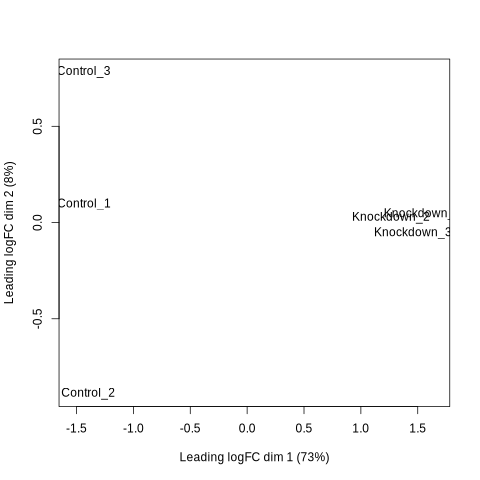

In [75]:
%%R
plotMDS(dge.scaled.filtr)

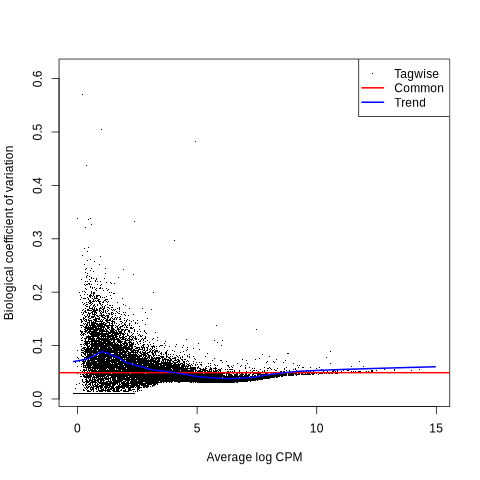

In [76]:
%%R
design <- model.matrix(~group-1,data = dge.scaled.filtr$samples)
colnames(design) <- gsub('group','',colnames(design))
dge.scaled.filtr <- estimateDisp(dge.scaled.filtr,design)
plotBCV(dge.scaled.filtr)

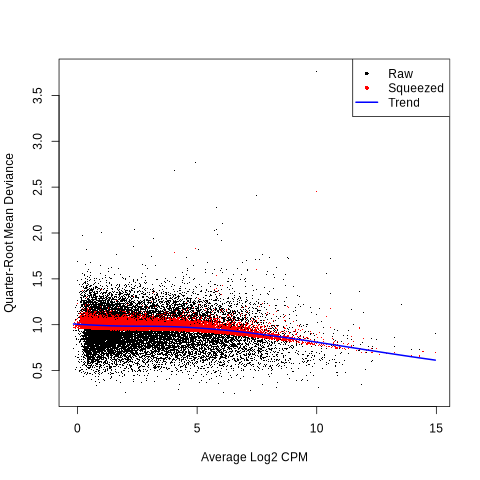

In [77]:
%%R
fit <- glmQLFit(dge.scaled.filtr,design)
plotQLDisp(fit)

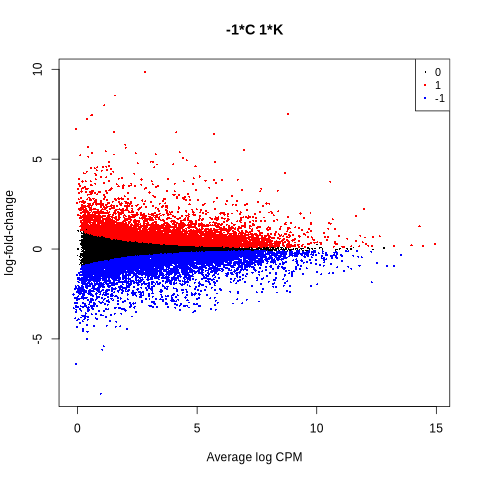

In [89]:
%%R
qlf <- glmQLFTest(fit, contrast = makeContrasts(K-C, levels = design))
tt <- topTags(qlf,n = Inf)
is.de <- decideTestsDGE(qlf)
plotMD(qlf, status = is.de, values = c(1, -1), col = c("red","blue"), legend = "topright", cex=0.4)

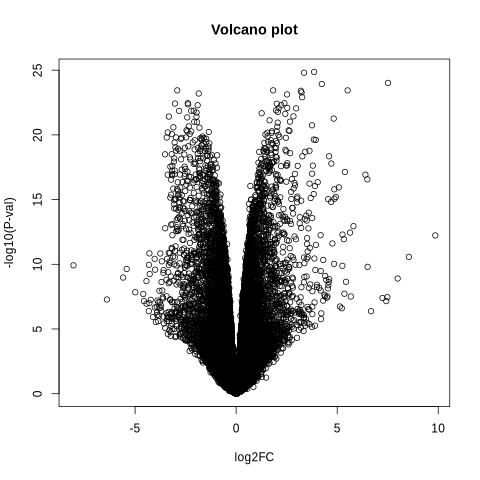

In [93]:
%%R
plot(qlf$table$logFC, -1*log10(qlf$table$PValue), main="Volcano plot", xlab="log2FC", ylab="-log10(P-val)")

In [83]:
%%R
head(qlf$table)

                        logFC   logCPM          F       PValue
ENST00000308647.8 -1.32899484 3.517359 96.1266689 1.560041e-09
ENST00000378736.3 -1.82460863 1.973150 61.9210577 7.222365e-08
ENST00000472194.6  0.70736286 1.937082  8.8197577 7.021779e-03
ENST00000673477.1 -1.45882163 1.216723 23.7937276 6.898508e-05
ENST00000447513.7 -0.08097798 1.704221  0.1357193 7.194394e-01
ENST00000356607.9 -0.23546078 4.883464  8.6774710 7.423889e-03
